# 1. Import libraries

In [1]:
import os
import shutil

import numpy as np
from tqdm import tqdm as tqdm

from agent import Agent
from environment import LunarLanderEnvironment
from plot_script import plot_result
from rl_glue import RLGlue

# Base agent
from __future__ import print_function
from abc import ABCMeta, abstractmethod

from copy import deepcopy

- *os* 
- *random* is used for agent exploration
- *clear_output* is used for updating the Tic-Tac-Toe board
- *matplotlib.pylab* and *numpy* are used to show the agent's learning

In [2]:

class BaseAgent:
    """Implements the agent for an RL-Glue environment.
    Note:
        agent_init, agent_start, agent_step, agent_end, agent_cleanup, and
        agent_message are required methods.
    """

    __metaclass__ = ABCMeta

    def __init__(self):
        pass

    @abstractmethod
    def agent_init(self, agent_info= {}):
        """Setup for the agent called when the experiment first starts."""

    @abstractmethod
    def agent_start(self, observation):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            observation (Numpy array): the state observation from the environment's evn_start function.
        Returns:
            The first action the agent takes.
        """

    @abstractmethod
    def agent_step(self, reward, observation):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            observation (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """

    @abstractmethod
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the terminal state.
        """

    @abstractmethod
    def agent_cleanup(self):
        """Cleanup done after the agent ends."""

    @abstractmethod
    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """


In [3]:

class Adam():
    def __init__(self, layer_sizes,
                 optimizer_info):
        self.layer_sizes = layer_sizes

        # Specify Adam algorithm's hyper parameters
        self.step_size = optimizer_info.get("step_size")
        self.beta_m = optimizer_info.get("beta_m")
        self.beta_v = optimizer_info.get("beta_v")
        self.epsilon = optimizer_info.get("epsilon")

        # Initialize Adam algorithm's m and v
        self.m = [dict() for i in range(1, len(self.layer_sizes))]
        self.v = [dict() for i in range(1, len(self.layer_sizes))]

        for i in range(0, len(self.layer_sizes) - 1):
            # The initialization for m and v should look very much like the initializations of the weights
            # except for the fact that initialization here is to zeroes (see description above.)
            self.m[i]["W"] = np.zeros((self.layer_sizes[i], self.layer_sizes[i + 1]))
            self.m[i]["b"] = np.zeros((1, self.layer_sizes[i + 1]))
            self.v[i]["W"] = np.zeros((self.layer_sizes[i], self.layer_sizes[i + 1]))
            self.v[i]["b"] = np.zeros((1, self.layer_sizes[i + 1]))

        self.beta_m_product = self.beta_m
        self.beta_v_product = self.beta_v

    def update_weights(self, weights, td_errors_times_gradients):
        """
        Args:
            weights (Array of dictionaries): The weights of the neural network.
            td_errors_times_gradients (Array of dictionaries): The gradient of the
            action-values with respect to the network's weights times the TD-error
        Returns:
            The updated weights (Array of dictionaries).
        """
        for i in range(len(weights)):
            for param in weights[i].keys():
                # First, you should update m and v and then compute
                # m_hat and v_hat. Finally, compute how much the weights should be incremented by.

                self.m[i][param] = self.beta_m * self.m[i][param] + (1 - self.beta_m) * td_errors_times_gradients[i][
                    param]
                self.v[i][param] = self.beta_v * self.v[i][param] + (1 - self.beta_v) * td_errors_times_gradients[i][
                    param] ** 2
                m_hat = self.m[i][param] / (1 - self.beta_m_product)
                v_hat = self.v[i][param] / (1 - self.beta_v_product)
                weight_update = (self.step_size / (np.sqrt(v_hat) + self.epsilon)) * m_hat

                weights[i][param] = weights[i][param] + weight_update
        # Notice that to calculate m_hat and v_hat, we use powers of beta_m and beta_v to
        self.beta_m_product *= self.beta_m
        self.beta_v_product *= self.beta_v

        return weights

In [4]:


class ActionValueNetwork:

    def __init__(self, network_config):
        self.state_dim = network_config.get("state_dim")
        self.num_hidden_units = network_config.get("num_hidden_units")
        self.num_actions = network_config.get("num_actions")

        self.rand_generator = np.random.RandomState(network_config.get("seed"))

        self.layer_sizes = [self.state_dim, self.num_hidden_units, self.num_actions]

        # Initialize the weights of the neural network
        # self.weights is an array of dictionaries with each dictionary corresponding to
        # the weights from one layer to the next. Each dictionary includes W and b
        self.weights = [dict() for i in range(0, len(self.layer_sizes) - 1)]
        for i in range(0, len(self.layer_sizes) - 1):
            self.weights[i]['W'] = self.init_saxe(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.weights[i]['b'] = np.zeros((1, self.layer_sizes[i + 1]))

    def get_action_values(self, s):
        """
        Args:
            s (Numpy array): The state.
        Returns:
            The action-values (Numpy array) calculated using the network's weights.
        """

        W0, b0 = self.weights[0]['W'], self.weights[0]['b']
        psi = np.dot(s, W0) + b0
        x = np.maximum(psi, 0)

        W1, b1 = self.weights[1]['W'], self.weights[1]['b']
        q_vals = np.dot(x, W1) + b1

        return q_vals


    def get_TD_update(self, s, delta_mat):
        """
        Args:
            s (Numpy array): The state.
            delta_mat (Numpy array): A 2D array of shape (batch_size, num_actions). Each row of delta_mat
            correspond to one state in the batch. Each row has only one non-zero element
            which is the TD-error corresponding to the action taken.
        Returns:
            The TD update (Array of dictionaries with gradient times TD errors) for the network's weights
        """

        W0, b0 = self.weights[0]['W'], self.weights[0]['b']
        W1, b1 = self.weights[1]['W'], self.weights[1]['b']

        psi = np.dot(s, W0) + b0
        x = np.maximum(psi, 0)
        dx = (psi > 0).astype(float)

        # td_update has the same structure as self.weights, that is an array of dictionaries.
        # td_update[0]["W"], td_update[0]["b"], td_update[1]["W"], and td_update[1]["b"] have the same shape as
        # self.weights[0]["W"], self.weights[0]["b"], self.weights[1]["W"], and self.weights[1]["b"] respectively
        td_update = [dict() for i in range(len(self.weights))]

        v = delta_mat
        td_update[1]['W'] = np.dot(x.T, v) * 1. / s.shape[0]
        td_update[1]['b'] = np.sum(v, axis=0, keepdims=True) * 1. / s.shape[0]

        v = np.dot(v, W1.T) * dx
        td_update[0]['W'] = np.dot(s.T, v) * 1. / s.shape[0]
        td_update[0]['b'] = np.sum(v, axis=0, keepdims=True) * 1. / s.shape[0]

        return td_update


    def init_saxe(self, rows, cols):
        """
        Args:
            rows (int): number of input units for layer.
            cols (int): number of output units for layer.
        Returns:
            NumPy Array consisting of weights for the layer based on the initialization in Saxe et al.
        """
        tensor = self.rand_generator.normal(0, 1, (rows, cols))
        if rows < cols:
            tensor = tensor.T
        tensor, r = np.linalg.qr(tensor)
        d = np.diag(r, 0)
        ph = np.sign(d)
        tensor *= ph

        if rows < cols:
            tensor = tensor.T
        return tensor


    def get_weights(self):
        """
        Returns:
            A copy of the current weights of this network.
        """
        return deepcopy(self.weights)


    def set_weights(self, weights):
        """
        Args:
            weights (list of dictionaries): Consists of weights that this network will set as its own weights.
        """
        self.weights = deepcopy(weights)

In [5]:

def softmax(action_values, tau=1.0):
    """
    Args:
        action_values (Numpy array): A 2D array of shape (batch_size, num_actions). 
                       The action-values computed by an action-value network.              
        tau (float): The temperature parameter scalar.
    Returns:
        A 2D array of shape (batch_size, num_actions). Where each column is a probability distribution over
        the actions representing the policy.
    """
    
    # Compute the preferences by dividing the action-values by the temperature parameter tau
    preferences = None
    # Compute the maximum preference across the actions
    max_preference = None
    
    # your code here
    preferences = action_values / tau
    max_preference = np.max(preferences, axis = 1) 
    
    
    # Reshape max_preference array which has shape [Batch,] to [Batch, 1]. This allows NumPy broadcasting 
    # when subtracting the maximum preference from the preference of each action.
    reshaped_max_preference = max_preference.reshape((-1, 1))
    
    # Compute the numerator, i.e., the exponential of the preference - the max preference.
    exp_preferences = None
    # Compute the denominator, i.e., the sum over the numerator along the actions axis.
    sum_of_exp_preferences = None
    
    # your code here
    exp_preferences = np.exp(preferences - reshaped_max_preference)
    sum_of_exp_preferences = np.sum(exp_preferences, axis = 1)
    
    # Reshape sum_of_exp_preferences array which has shape [Batch,] to [Batch, 1] to  allow for NumPy broadcasting 
    # when dividing the numerator by the denominator.
    reshaped_sum_of_exp_preferences = sum_of_exp_preferences.reshape((-1, 1))
    
    # Compute the action probabilities according to the equation in the previous cell.
    action_probs = None
    
    # your code here
    action_probs = exp_preferences / reshaped_sum_of_exp_preferences
    
    
    # squeeze() removes any singleton dimensions. It is used here because this function is used in the 
    # agent policy when selecting an action (for which the batch dimension is 1.) As np.random.choice is used in 
    # the agent policy and it expects 1D arrays, we need to remove this singleton batch dimension.
    action_probs = action_probs.squeeze()
    return action_probs

In [6]:
def optimize_network(experiences, discount, optimizer, network, current_q, tau):
    """
    Args:
        experiences (Numpy array): The batch of experiences including the states, actions, 
                                   rewards, terminals, and next_states.
        discount (float): The discount factor.
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    """
    
    # Get states, action, rewards, terminals, and next_states from experiences
    states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
    states = np.concatenate(states)
    next_states = np.concatenate(next_states)
    rewards = np.array(rewards)
    terminals = np.array(terminals)
    batch_size = states.shape[0]

    # Compute TD error using the get_td_error function
    # Note that q_vec is a 1D array of shape (batch_size)
    delta_vec = get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau)

    # Batch Indices is an array from 0 to the batch_size - 1. 
    batch_indices = np.arange(batch_size)

    # Make a td error matrix of shape (batch_size, num_actions)
    # delta_mat has non-zero value only for actions taken
    delta_mat = np.zeros((batch_size, network.num_actions))
    delta_mat[batch_indices, actions] = delta_vec

    # Pass delta_mat to compute the TD errors times the gradients of the network's weights from back-propagation
    
    ### START CODE HERE
    td_update = network.get_TD_update(states, delta_mat)
    ### END CODE HERE
    # your code here
    
    
    # Pass network.get_weights and the td_update to the optimizer to get updated weights
    ### START CODE HERE
    weights = optimizer.update_weights(network.get_weights(), td_update)
    ### END CODE HERE
    # your code here
    
    
    network.set_weights(weights)/tmp/ipykernel_36347/1922077970.py in plot_result(data_name_array)

In [7]:
def get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau):
    """
    Args:
        states (Numpy array): The batch of states with the shape (batch_size, state_dim).
        next_states (Numpy array): The batch of next states with the shape (batch_size, state_dim).
        actions (Numpy array): The batch of actions with the shape (batch_size,).
        rewards (Numpy array): The batch of rewards with the shape (batch_size,).
        discount (float): The discount factor.
        terminals (Numpy array): The batch of terminals with the shape (batch_size,).
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    Returns:
        The TD errors (Numpy array) for actions taken, of shape (batch_size,)
    """
    
    # Note: Here network is the latest state of the network that is getting replay updates. In other words, 
    # the network represents Q_{t+1}^{i} whereas current_q represents Q_t, the fixed network used for computing the 
    # targets, and particularly, the action-values at the next-states.
    
    # Compute action values at next states using current_q network
    # Note that q_next_mat is a 2D array of shape (batch_size, num_actions)
    
    ### START CODE HERE (~1 Line)
    q_next_mat = current_q.get_action_values(next_states)
    ### END CODE HERE
    # your code here
    
    # Compute policy at next state by passing the action-values in q_next_mat to softmax()
    # Note that probs_mat is a 2D array of shape (batch_size, num_actions)
    
    ### START CODE HERE (~1 Line)
    probs_mat = softmax(q_next_mat, tau)
    ### END CODE HERE
    # your code here
    
    # Compute the estimate of the next state value, v_next_vec.
    # Hint: sum the action-values for the next_states weighted by the policy, probs_mat. Then, multiply by
    # (1 - terminals) to make sure v_next_vec is zero for terminal next states.
    # Note that v_next_vec is a 1D array of shape (batch_size,)
    
    ### START CODE HERE (~3 Lines)
    v_next_vec = np.sum(q_next_mat * probs_mat, axis=1)
    v_next_vec = v_next_vec * ( 1- terminals)
    ### END CODE HERE
    # your code here
    
    # Compute Expected Sarsa target
    # Note that target_vec is a 1D array of shape (batch_size,)
    
    ### START CODE HERE (~1 Line)
    target_vec = rewards + discount * v_next_vec
    ### END CODE HERE
    # your code here
    
    # Compute action values at the current states for all actions using network
    # Note that q_mat is a 2D array of shape (batch_size, num_actions)
    
    ### START CODE HERE (~1 Line)
    q_mat = network.get_action_values(states)
    ### END CODE HERE
    # your code here
    
    # Batch Indices is an array from 0 to the batch size - 1. 
    batch_indices = np.arange(q_mat.shape[0])

    # Compute q_vec by selecting q(s, a) from q_mat for taken actions
    # Use batch_indices as the index for the first dimension of q_mat
    # Note that q_vec is a 1D array of shape (batch_size)
    
    ### START CODE HERE (~1 Line)
    q_vec = q_mat[batch_indices, actions]
    ### END CODE HERE
    # your code here
    
    # Compute TD errors for actions taken
    # Note that delta_vec is a 1D array of shape (batch_size)
    
    ### START CODE HERE (~1 Line)
    delta_vec = target_vec - q_vec
    ### END CODE HERE
    # your code here
    
    return delta_vec

In [8]:


class ReplayBuffer:
    def __init__(self, size, minibatch_size, seed):
        """
        Args:
            size (integer): The size of the replay buffer.
            minibatch_size (integer): The sample size.
            seed (integer): The seed for the random number generator.
        """
        self.buffer = []
        self.minibatch_size = minibatch_size
        self.rand_generator = np.random.RandomState(seed)
        self.max_size = size

    def append(self, state, action, reward, terminal, next_state):
        """
        Args:
            state (Numpy array): The state.
            action (integer): The action.
            reward (float): The reward.
            terminal (integer): 1 if the next state is a terminal state and 0 otherwise.
            next_state (Numpy array): The next state.
        """
        if len(self.buffer) == self.max_size:
            del self.buffer[0]
        self.buffer.append([state, action, reward, terminal, next_state])

    def sample(self):
        """
        Returns:
            A list of transition tuples including state, action, reward, terinal, and next_state
        """
        idxs = self.rand_generator.choice(np.arange(len(self.buffer)), size=self.minibatch_size)
        return [self.buffer[idx] for idx in idxs]

    def size(self):
        return len(self.buffer)

In [9]:

class Agent(BaseAgent):
    def __init__(self):
        self.name = "expected_sarsa_agent"

    # Work Required: No.
    def agent_init(self, agent_config):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the agent.

        Assume agent_config dict contains:
        {
            network_config: dictionary,
            optimizer_config: dictionary,
            replay_buffer_size: integer,
            minibatch_sz: integer,
            num_replay_updates_per_step: float
            discount_factor: float,
        }
        """
        self.replay_buffer = ReplayBuffer(agent_config['replay_buffer_size'],
                                          agent_config['minibatch_sz'], agent_config.get("seed"))
        self.network = ActionValueNetwork(agent_config['network_config'])
        self.optimizer = Adam(self.network.layer_sizes, agent_config["optimizer_config"])
        self.num_actions = agent_config['network_config']['num_actions']
        self.num_replay = agent_config['num_replay_updates_per_step']
        self.discount = agent_config['gamma']
        self.tau = agent_config['tau']

        self.rand_generator = np.random.RandomState(agent_config.get("seed"))

        self.last_state = None
        self.last_action = None

        self.sum_rewards = 0
        self.episode_steps = 0

    # Work Required: No.
    def policy(self, state):
        """
        Args:
            state (Numpy array): the state.
        Returns:
            the action.
        """
        action_values = self.network.get_action_values(state)
        probs_batch = softmax(action_values, self.tau)
        action = self.rand_generator.choice(self.num_actions, p=probs_batch.squeeze())
        return action

    # Work Required: No.
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        self.sum_rewards = 0
        self.episode_steps = 0
        self.last_state = np.array([state])
        self.last_action = self.policy(self.last_state)
        return self.last_action

    # Work Required: Yes. Fill in the action selection, replay-buffer update,
    # weights update using optimize_network, and updating last_state and last_action (~5 lines).
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """

        self.sum_rewards += reward
        self.episode_steps += 1

        # Make state an array of shape (1, state_dim) to add a batch dimension and
        # to later match the get_action_values() and get_TD_update() functions
        state = np.array([state])

        # Select action
        # your code here
        action = self.policy(state)

        # Append new experience to replay buffer
        # Note: look at the replay_buffer append function for the order of arguments

        # your code here
        self.replay_buffer.append(self.last_state, self.last_action, reward, 0, state)

        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()

                # Call optimize_network to update the weights of the network (~1 Line)
                # your code here
                optimize_network(experiences, self.discount, self.optimizer, self.network, current_q, self.tau)

        # Update the last state and last action.
        ### START CODE HERE (~2 Lines)
        self.last_state = state
        self.last_action = action
        ### END CODE HERE
        # your code here

        return action

    # Work Required: Yes. Fill in the replay-buffer update and
    # update of the weights using optimize_network (~2 lines).
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.sum_rewards += reward
        self.episode_steps += 1

        # Set terminal state to an array of zeros
        state = np.zeros_like(self.last_state)

        # Append new experience to replay buffer
        # Note: look at the replay_buffer append function for the order of arguments

        # your code here
        self.replay_buffer.append(self.last_state, self.last_action, reward, 1, state)

        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()

                # Call optimize_network to update the weights of the network
                # your code here
                optimize_network(experiences, self.discount, self.optimizer, self.network, current_q, self.tau)

    def agent_message(self, message):
        if message == "get_sum_reward":
            return self.sum_rewards
        else:
            raise Exception("Unrecognized Message!")

In [10]:
"""Abstract environment base class for RL-Glue-py.
"""

from __future__ import print_function

from abc import ABCMeta, abstractmethod


class BaseEnvironment:
    """Implements the environment for an RLGlue environment

    Note:
        env_init, env_start, env_step, env_cleanup, and env_message are required
        methods.
    """

    __metaclass__ = ABCMeta

    def __init__(self):
        reward = None
        observation = None
        termination = None
        self.reward_obs_term = (reward, observation, termination)

    @abstractmethod
    def env_init(self, env_info={}):
        """Setup for the environment called when the experiment first starts.

        Note:
            Initialize a tuple with the reward, first state observation, boolean
            indicating if it's terminal.
        """

    @abstractmethod
    def env_start(self):
        """The first method called when the experiment starts, called before the
        agent starts.

        Returns:
            The first state observation from the environment.
        """

    @abstractmethod
    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent

        Returns:
            (float, state, Boolean): a tuple of the reward, state observation,
                and boolean indicating if it's terminal.
        """

    @abstractmethod
    def env_cleanup(self):
        """Cleanup done after the environment ends"""

    @abstractmethod
    def env_message(self, message):
        """A message asking the environment for information

        Args:
            message: the message passed to the environment

        Returns:
            the response (or answer) to the message
        """


In [11]:

from abstract_environment import BaseEnvironment
import numpy as np
import gym

class LunarLanderEnvironment(BaseEnvironment):
    def env_init(self, env_info={}):
        """
        Setup for the environment called when the experiment first starts.
        """
        self.env = gym.make("LunarLander-v2", render_mode='human')
        #self.env.seed(0)

    def env_start(self):
        """
        The first method called when the experiment starts, called before the
        agent starts.

        Returns:
            The first state observation from the environment.
        """

        reward = 0.0
        observation = self.env.reset()
        is_terminal = False

        self.reward_obs_term = (reward, observation, is_terminal)

        # return first state observation from the environment
        return self.reward_obs_term[1][0]

    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent

        Returns:
            (float, state, Boolean): a tuple of the reward, state observation,
                and boolean indicating if it's terminal.
        """

        last_state = self.reward_obs_term[1]
        current_state, reward, is_terminal, _, _ = self.env.step(action)

        self.reward_obs_term = (reward, current_state, is_terminal)

        return self.reward_obs_term

In [12]:
"""Glues together an experiment, agent, and environment.
"""

from __future__ import print_function


class RLGlue:
    """RLGlue class

    args:
        env_name (string): the name of the module where the Environment class can be found
        agent_name (string): the name of the module where the Agent class can be found
    """

    def __init__(self, env_class, agent_class):
        self.environment = env_class()
        self.agent = agent_class()

        self.total_reward = None
        self.last_action = None
        self.num_steps = None
        self.num_episodes = None

    def rl_init(self, agent_init_info={}, env_init_info={}):
        """Initial method called when RLGlue experiment is created"""
        self.environment.env_init(env_init_info)
        self.agent.agent_init(agent_init_info)

        self.total_reward = 0.0
        self.num_steps = 0
        self.num_episodes = 0

    def rl_start(self, agent_start_info={}, env_start_info={}):
        """Starts RLGlue experiment

        Returns:
            tuple: (state, action)
        """

        self.total_reward = 0.0
        self.num_steps = 1

        last_state = self.environment.env_start()
        self.last_action = self.agent.agent_start(last_state)

        observation = (last_state, self.last_action)

        return observation

    def rl_agent_start(self, observation):
        """Starts the agent.

        Args:
            observation: The first observation from the environment

        Returns:
            The action taken by the agent.
        """
        return self.agent.agent_start(observation)

    def rl_agent_step(self, reward, observation):
        """Step taken by the agent

        Args:
            reward (float): the last reward the agent received for taking the
                last action.
            observation : the state observation the agent receives from the
                environment.

        Returns:
            The action taken by the agent.
        """
        return self.agent.agent_step(reward, observation)

    def rl_agent_end(self, reward):
        """Run when the agent terminates

        Args:
            reward (float): the reward the agent received when terminating
        """
        self.agent.agent_end(reward)

    def rl_env_start(self):
        """Starts RL-Glue environment.

        Returns:
            (float, state, Boolean): reward, state observation, boolean
                indicating termination
        """
        self.total_reward = 0.0
        self.num_steps = 1

        this_observation = self.environment.env_start()

        return this_observation

    def rl_env_step(self, action):
        """Step taken by the environment based on action from agent

        Args:
            action: Action taken by agent.

        Returns:
            (float, state, Boolean): reward, state observation, boolean
                indicating termination.
        """
        ro = self.environment.env_step(action)
        (this_reward, _, terminal) = ro

        self.total_reward += this_reward

        if terminal:
            self.num_episodes += 1
        else:
            self.num_steps += 1

        return ro

    def rl_step(self):
        """Step taken by RLGlue, takes environment step and either step or
            end by agent.

        Returns:
            (float, state, action, Boolean): reward, last state observation,
                last action, boolean indicating termination
        """

        (reward, last_state, term) = self.environment.env_step(self.last_action)

        self.total_reward += reward;

        if term:
            self.num_episodes += 1
            self.agent.agent_end(reward)
            roat = (reward, last_state, None, term)
        else:
            self.num_steps += 1
            self.last_action = self.agent.agent_step(reward, last_state)
            roat = (reward, last_state, self.last_action, term)

        return roat

    def rl_cleanup(self):
        """Cleanup done at end of experiment."""
        self.environment.env_cleanup()
        self.agent.agent_cleanup()

    def rl_agent_message(self, message):
        """Message passed to communicate with agent during experiment

        Args:
            message: the message (or question) to send to the agent

        Returns:
            The message back (or answer) from the agent

        """

        return self.agent.agent_message(message)

    def rl_env_message(self, message):
        """Message passed to communicate with environment during experiment

        Args:
            message: the message (or question) to send to the environment

        Returns:
            The message back (or answer) from the environment

        """
        return self.environment.env_message(message)

    def rl_episode(self, max_steps_this_episode):
        """Runs an RLGlue episode

        Args:
            max_steps_this_episode (Int): the maximum steps for the experiment to run in an episode

        Returns:
            Boolean: if the episode should terminate
        """
        is_terminal = False

        self.rl_start()

        while (not is_terminal) and ((max_steps_this_episode == 0) or
                                     (self.num_steps < max_steps_this_episode)):
            rl_step_result = self.rl_step()
            is_terminal = rl_step_result[3]

        return is_terminal

    def rl_return(self):
        """The total reward

        Returns:
            float: the total reward
        """
        return self.total_reward

    def rl_num_steps(self):
        """The total number of steps taken

        Returns:
            Int: the total number of steps taken
        """
        return self.num_steps

    def rl_num_episodes(self):
        """The number of episodes

        Returns
            Int: the total number of episodes

        """
        return self.num_episodes

Starting!


100%|██████████| 300/300 [44:02<00:00,  8.81s/it]

Finished!


FileNotFoundError: [Errno 2] No such file or directory: './/sum_reward_random_agent.npy'

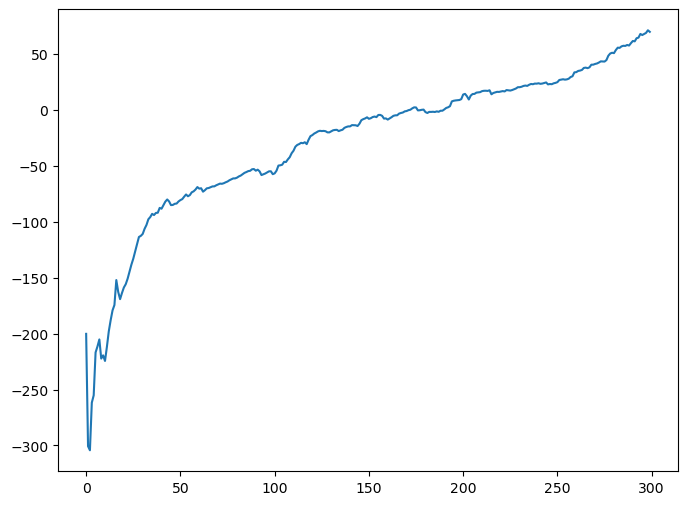

In [13]:

def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):
    rl_glue = RLGlue(environment, agent)

    # save sum of reward at the end of each episode
    agent_sum_reward = np.zeros((experiment_parameters["num_runs"],
                                 experiment_parameters["num_episodes"]))

    env_info = {}

    agent_info = agent_parameters

    # one agent setting
    for run in range(1, experiment_parameters["num_runs"] + 1):
        agent_info["seed"] = run
        agent_info["network_config"]["seed"] = run
        env_info["seed"] = run

        rl_glue.rl_init(agent_info, env_info)

        for episode in tqdm(range(1, experiment_parameters["num_episodes"] + 1)):
            # run episode
            rl_glue.rl_episode(experiment_parameters["timeout"])

            episode_reward = rl_glue.rl_agent_message("get_sum_reward")
            agent_sum_reward[run - 1, episode - 1] = episode_reward
    save_name = "{}".format(rl_glue.agent.name)
    if not os.path.exists('results'):
        os.makedirs('results')
    np.save("results/sum_reward_{}".format(save_name), agent_sum_reward)
    shutil.make_archive('results', 'zip', 'results')


def main():
    # Run Experiment

    # Experiment parameters
    experiment_parameters = {
        "num_runs": 1,
        "num_episodes": 300,
        # OpenAI Gym environments allow for a timestep limit timeout, causing episodes to end after
        # some number of timesteps. Here we use the default of 500.
        "timeout": 500
    }

    # Environment parameters
    environment_parameters = {}

    current_env = LunarLanderEnvironment

    # Agent parameters
    agent_parameters = {
        'network_config': {
            'state_dim': 8,
            'num_hidden_units': 256,
            'num_actions': 4
        },
        'optimizer_config': {
            'step_size': 1e-3,
            'beta_m': 0.9,
            'beta_v': 0.999,
            'epsilon': 1e-8
        },
        'replay_buffer_size': 50000,
        'minibatch_sz': 8,
        'num_replay_updates_per_step': 4,
        'gamma': 0.99,
        'tau': 0.001
    }
    current_agent = Agent

    # run experiment
    run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)


# Press the green button in the gutter to run the script.
if __name__ == '__main__':
    print("Starting!")
    main()
    print("Finished!")
    plot_result(["expected_sarsa_agent"])


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

plt_legend_dict = {"expected_sarsa_agent": "Expected SARSA with neural network",
                   "random_agent": "Random"}
path_dict = {"expected_sarsa_agent": "results/",
             "random_agent": "./"}

plt_label_dict = {"expected_sarsa_agent": "Sum of\nreward\nduring\nepisode"}


def smooth(data, k):
    num_episodes = data.shape[1]
    num_runs = data.shape[0]

    smoothed_data = np.zeros((num_runs, num_episodes))

    for i in range(num_episodes):
        if i < k:
            smoothed_data[:, i] = np.mean(data[:, :i + 1], axis=1)
        else:
            smoothed_data[:, i] = np.mean(data[:, i - k:i + 1], axis=1)

    return smoothed_data


# Function to plot result
def plot_result(data_name_array):
    plt_agent_sweeps = []

    fig, ax = plt.subplots(figsize=(8, 6))

    for data_name in data_name_array:
        # load data
        filename = 'sum_reward_{}'.format(data_name).replace('.', '')
        sum_reward_data = np.load('{}/{}.npy'.format(path_dict[data_name], filename))

        # smooth data
        smoothed_sum_reward = smooth(data=sum_reward_data, k=100)

        mean_smoothed_sum_reward = np.mean(smoothed_sum_reward, axis=0)

        plot_x_range = np.arange(0, mean_smoothed_sum_reward.shape[0])
        graph_current_agent_sum_reward, = ax.plot(plot_x_range, mean_smoothed_sum_reward[:],
                                                  label=plt_legend_dict[data_name])
        plt_agent_sweeps.append(graph_current_agent_sum_reward)

    ax.legend(handles=plt_agent_sweeps, fontsize=13)
    ax.set_title("Learning Curve", fontsize=15)
    ax.set_xlabel('Episodes', fontsize=14)
    ax.set_ylabel(plt_label_dict[data_name_array[0]], rotation=0, labelpad=40, fontsize=14)
    ax.set_ylim([-300, 300])

    plt.tight_layout()
    plt.show()


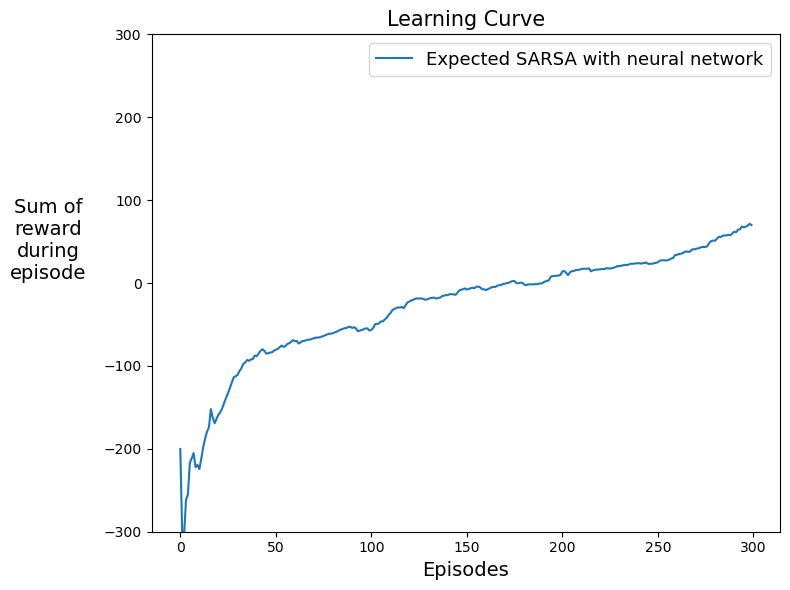

In [2]:
plot_result(["expected_sarsa_agent"])